In [68]:
import pandas as pd
import numpy as np
import seaborn as sns  
import matplotlib.pyplot as plt

og_data = pd.read_csv('f1_data_og.csv')

In [69]:
og_data = og_data.rename(columns = {
    'driver_wins': 'team_wins',
    'constructor_wins': 'driver_wins'
})

og_data.columns

Index(['Unnamed: 0', 'season', 'round', 'date', 'driverId', 'grid', 'statusId',
       'position', 'dob', 'driver_nationality', 'team_name',
       'team_nationality', 'GP_circuit', 'country', 'constructorStandingsId',
       'team_wins', 'driverStandingsId', 'driver_wins', 'driver_age',
       'driver_dnf', 'constructor_dnf', 'driver', 'driver_home', 'team_home',
       'race_winner', 'podium_winner', 'pos_delta', 'driver_dnf_ratio',
       'active_driver', 'active_constructor'],
      dtype='object')

Constructing a new data frame to make predictions on race winner or podium winner.

In [70]:
cleaned_df = og_data[['season', 'round','GP_circuit', 'grid','team_name','driver','driver_age', 'driver_wins', 'team_wins', 'pos_delta','driver_dnf_ratio','race_winner', 'podium_winner']]
cleaned_df

,season,round,GP_circuit,grid,team_name,driver,driver_age,driver_wins,team_wins,pos_delta,driver_dnf_ratio,race_winner,podium_winner
0,2009,1,Albert Park Grand Prix Circuit,1,Brawn,Jenson Button,29.0,1,1,0,0.072797,1,1
1,2009,1,Albert Park Grand Prix Circuit,2,Brawn,Rubens Barrichello,37.0,0,1,0,0.089623,0,1
2,2007,1,Albert Park Grand Prix Circuit,14,Honda,Jenson Button,27.0,0,0,0,0.072797,0,0
3,2007,1,Albert Park Grand Prix Circuit,16,Honda,Rubens Barrichello,35.0,0,0,-1,0.089623,0,0
4,2006,3,Albert Park Grand Prix Circuit,1,Honda,Jenson Button,26.0,0,0,0,0.072797,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9557,2021,20,Losail International Circuit,18,Alfa Romeo,Antonio Giovinazzi,28.0,0,0,0,0.081967,0,0
9558,2021,20,Losail International Circuit,19,Haas F1 Team,Mick Schumacher,23.0,0,0,0,0.069767,0,0
9559,2021,20,Losail International Circuit,20,Haas F1 Team,Nikita Mazepin,23.0,0,0,0,0.136364,0,0
9560,2021,20,Losail International Circuit,2,AlphaTauri,Pierre Gasly,26.0,0,0,-2,0.084034,0,0


# Cleaned Data Frame Dictionary

|Feature          |Definition                                             |
|:---------------:|:------------------------------------------------------|
|Season (int)           |The year in which the race takes place                |
|Round (int)            |The specific round in the season |    
|GP_circuit (str) | The circuit at which the race occurs|
|grid (int) | Starting position of each driver|
|team_name (str) | Constructor Name|
|driver (str) | The name of each driver|
|driver_age (int) | The age of each driver|
|driver_wins (int) | The number of wins a driver has in that season at time of race|
|constructor_wins (int) | The number of wins a team has at a specific point in the season|
|pos_delta (int) | How many positions gained or lost in a race|
|driver_dnf_ratio (float) | The ratio of unfinished races to total races entered|
|race_winner (int) | Target Var - binary variable for race winner|
|podium_winner (int)| Target Var - binary variable for podium finisher|

# Data Pre-Processing


In [71]:
#V10 Engine Era is the reason for sectioning of more data to the year 2000 and onwards
cleaned_df = cleaned_df[cleaned_df.season >= 2000]

## One-Hot Encoding

In [72]:
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import LabelEncoder, OneHotEncoder 

# Step 1: Encode Categorical Features

# one-hot encoding for 'GP_circuit' and 'team_name':
cleaned_df = pd.get_dummies(cleaned_df, columns=['GP_circuit', 'team_name'])

## Data Splitting

In [73]:
#Train on data from 2000 - 2018
train_data = cleaned_df[(cleaned_df['season'] >= 2000) & (cleaned_df['season'] < 2019)]

#Validate on data from 2019-2022
validation_data = cleaned_df[(cleaned_df['season'] >= 2019) & (cleaned_df['season'] <= 2022)]

#Test on 2023 grand prix using a function we will define after model selection
test_data = cleaned_df[(cleaned_df['season'] == 2023)]

## Function for Splitting and Scaling data 

In [74]:
from sklearn.preprocessing import RobustScaler
def split_data_winner(GP_circuit, train = train_data, val = validation_data, test = test_data):

    """
    GP_circuit = 'GP_circuit_circuit_name'
    """
    gp = GP_circuit

    train = train.loc[train[gp] == 1, :]
    val = val.loc[val[gp] == 1, :]
    test = test.loc[test[gp] == 1, :]

    #X split
    X_train = train.drop(['driver', 'podium_winner', 'race_winner'], axis = 1)
    X_val = val.drop(['driver', 'podium_winner', 'race_winner'], axis = 1)
    X_test = test.drop(['driver', 'podium_winner', 'race_winner'], axis = 1)

    #y split
    y_train = train['race_winner']
    y_val = val['race_winner']
    y_test = test['race_winner']

    scaler = RobustScaler()

    #Only fit on training data and transform on all
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

In [75]:
from sklearn.preprocessing import RobustScaler
def split_data_podium(GP_circuit, train = train_data, val = validation_data, test = test_data):

    """
    GP_circuit = 'GP_circuit_circuit_name'
    """
    gp = GP_circuit

    train = train.loc[train[gp] == 1, :]
    val = val.loc[val[gp] == 1, :]
    test = test.loc[test[gp] == 1, :]

    #X split
    X_train = train.drop(['driver', 'podium_winner', 'race_winner'], axis = 1)
    X_val = val.drop(['driver', 'podium_winner', 'race_winner'], axis = 1)
    X_test = test.drop(['driver', 'podium_winner', 'race_winner'], axis = 1)

    #y split
    y_train = train['podium_winner']
    y_val = val['podium_winner']
    y_test = test['podium_winner']

    scaler = RobustScaler()

    #Only fit on training data and transform on all
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_val_scaled, X_test_scaled, y_train, y_val, y_test

# Model Building

Making this function dynamic in the sense that we can test our model on different 2023 GP's and predicting both winners and podium placers


In [76]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
def model(GP_circuit, model, prediction, test = test_data):
  """ GP_circuit = 'race_title' <-- get from 2023 race list
      model = 'SVM', 'Logistic Regression'
      prediction = 'podium' or 'winner'
      --> first run split and scale func
      --> if statement for either log reg or svm
      --> get score for train, val and test
  """

  gp = "GP_circuit_" + GP_circuit

  if prediction == 'podium':
    X_train, X_val, X_test, y_train, y_val, y_test = split_data_podium(gp)
  
  elif prediction == 'winner':
    X_train, X_val, X_test, y_train, y_val, y_test = split_data_winner(gp)

  else:

    raise Exception("Please input a correct prediction type: 'podium' or 'winner'")
 

  if model == 'SVM': 
    svm_mod = SVC(kernel='linear', C=1, random_state=42, probability= True)
    svm_mod.fit(X_train, y_train)
    train_score = svm_mod.score(X_train, y_train)
    val_score = svm_mod.score(X_val, y_val)
    test_score = svm_mod.score(X_test, y_test)

    print('SVM Train Score:', train_score)
    print('SVM Validation Score:', val_score)
    print('SVM Test Score:', test_score)

    #Predict probabilties for test
    probas = svm_mod.predict_proba(X_test)
    # probability of winning
    prob_winning = probas[:,1]

    # predictions
    drivers = test[test[gp] == 1].driver
    results = pd.Series(prob_winning, index=drivers)
    # print(results.sort_values(ascending=False))

    return train_score, val_score, test_score

  elif model == 'Logistic Regression':
    log_reg_mod = LogisticRegression(max_iter = 3000, C=50, penalty='l2')
    log_reg_mod.fit(X_train, y_train)
    train_score = log_reg_mod.score(X_train, y_train)
    val_score = log_reg_mod.score(X_val, y_val)
    test_score = log_reg_mod.score(X_test, y_test)


    print('Logistic Regression Train Score:', train_score)
    print('Logistic Regression Validation Score:', val_score)
    print('Logistic Regression Test Score:', test_score)

    #Predict probabilties for test
    probas = log_reg_mod.predict_proba(X_test)
    # probability of winning
    prob_winning = probas[:,1]

    # predictions
    drivers = test[test[gp] == 1].driver
    results = pd.Series(prob_winning, index=drivers)
    # print(results.sort_values(ascending=False))

    return train_score, val_score, test_score
  
  else:
    raise Exception("Please enter one of the following models: SVM or Logistic Regression")
        

  




## Predictions for Race Winner on 2023 GP's

SVM Train Score: 0.9509803921568627
SVM Validation Score: 0.95
SVM Test Score: 0.95
SVM Train Score: 0.958904109589041
SVM Validation Score: 0.96
SVM Test Score: 0.95
SVM Train Score: 0.9646017699115044
SVM Validation Score: 0.975
SVM Test Score: 0.95
SVM Train Score: 0.9616519174041298
SVM Validation Score: 0.9491525423728814
SVM Test Score: 0.95
SVM Train Score: 0.9724517906336089
SVM Validation Score: 0.95
SVM Test Score: 0.95
SVM Train Score: 0.973293768545994
SVM Validation Score: 0.95
SVM Test Score: 1.0
SVM Train Score: 0.9695945945945946
SVM Validation Score: 0.9375
SVM Test Score: 0.9
SVM Train Score: 0.96875
SVM Validation Score: 0.95
SVM Test Score: 1.0
SVM Train Score: 0.9516129032258065
SVM Validation Score: 0.95
SVM Test Score: 0.95
SVM Train Score: 0.9836065573770492
SVM Validation Score: 0.9166666666666666
SVM Test Score: 0.85


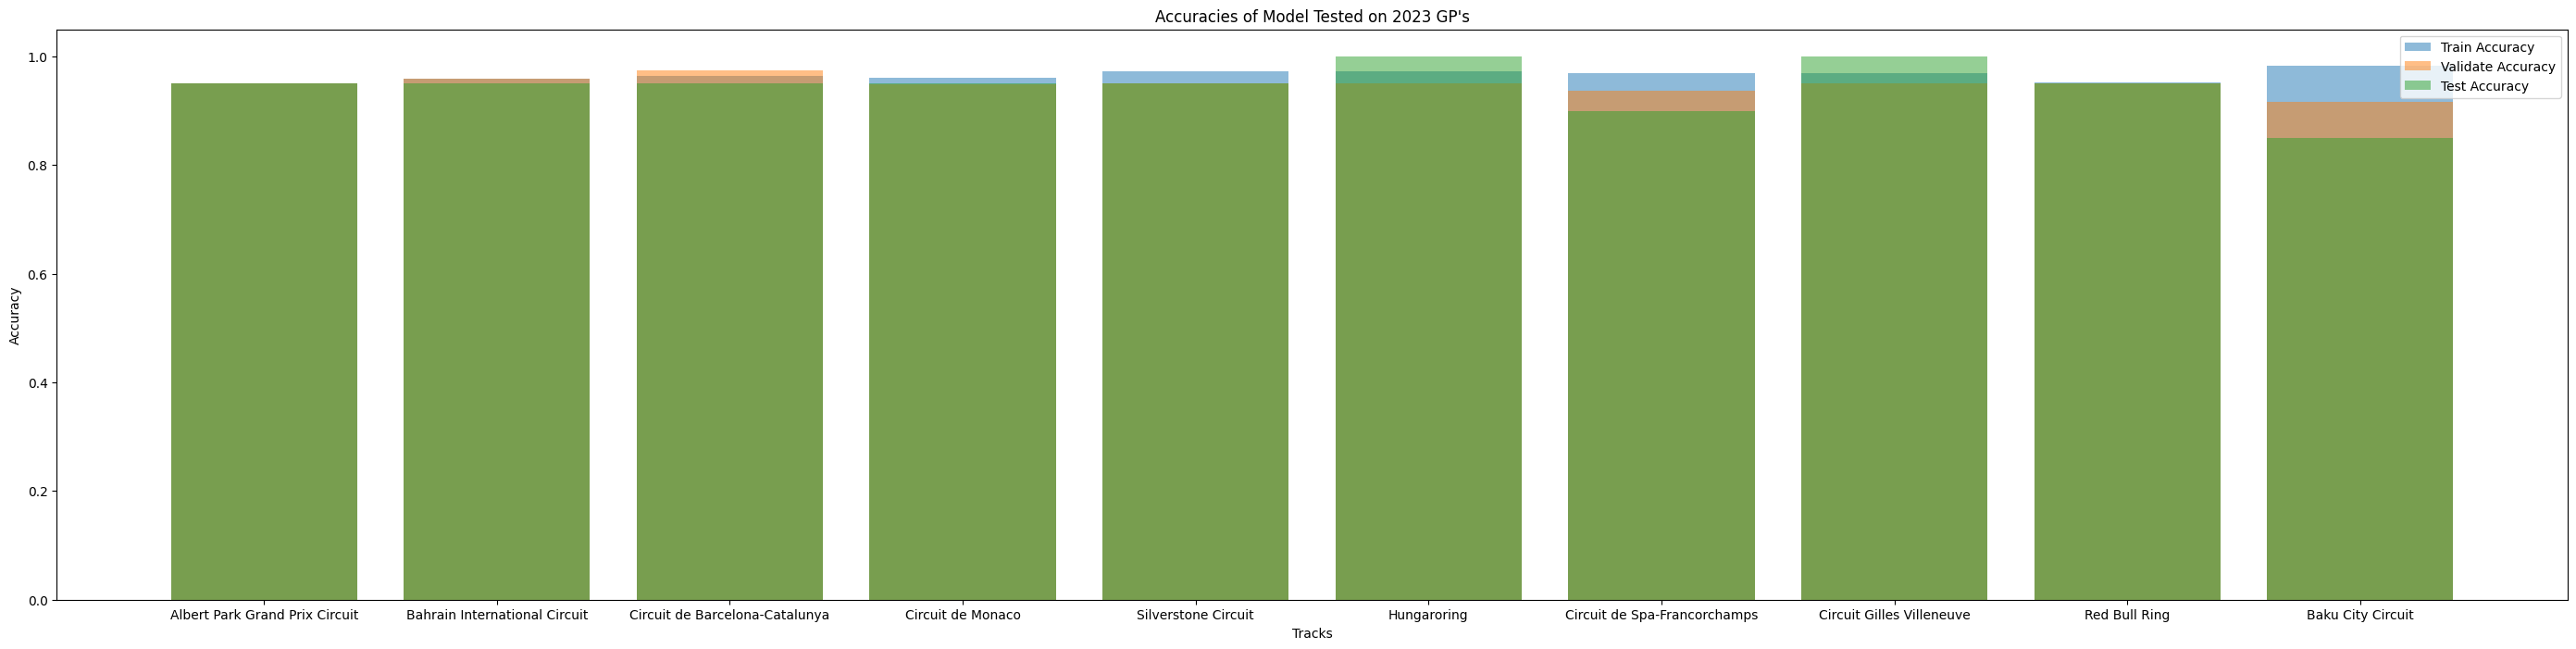

In [77]:
tracks = ['Albert Park Grand Prix Circuit',
 'Bahrain International Circuit',
 'Circuit de Barcelona-Catalunya',
 'Circuit de Monaco',
 'Silverstone Circuit',
 'Hungaroring',
 'Circuit de Spa-Francorchamps',
 'Circuit Gilles Villeneuve',
 'Red Bull Ring',
 'Baku City Circuit']

train_scores = []
val_scores = []
test_scores = []

for track in tracks:
    train_score, val_score, test_score = model(track, 'SVM', 'winner')
    train_scores.append(train_score)
    val_scores.append(val_score)
    test_scores.append(test_score)

# Plot accuracies
plt.figure(figsize=(35, 8))
plt.bar([track for track in tracks], train_scores, alpha=0.5, label='Train Accuracy')
plt.bar([track for track in tracks], val_scores, alpha=0.5, label='Validate Accuracy')
plt.bar([track for track in tracks], test_scores, alpha=0.5, label='Test Accuracy')
plt.xlabel('Tracks')
plt.ylabel('Accuracy')
plt.title("Accuracies of Model Tested on 2023 GP's")
plt.legend(loc='best')
plt.show()

Mean Scores for Training and Testing Set:

In [78]:
training_mean = np.mean(train_scores)
testing_mean = np.mean(test_scores)

print('The mean training set score is:', training_mean)
print('The mean testing set score is:', testing_mean)

The mean training set score is: 0.965544780343859
The mean testing set score is: 0.945


## Predictions for Podium Placers on 2023 GP's

SVM Train Score: 0.9803921568627451
SVM Validation Score: 0.975
SVM Test Score: 0.95
SVM Train Score: 0.9828767123287672
SVM Validation Score: 0.97
SVM Test Score: 1.0
SVM Train Score: 0.9793510324483776
SVM Validation Score: 0.9625
SVM Test Score: 0.9
SVM Train Score: 0.9793510324483776
SVM Validation Score: 0.9322033898305084
SVM Test Score: 0.9
SVM Train Score: 0.9889807162534435
SVM Validation Score: 0.95
SVM Test Score: 0.95
SVM Train Score: 0.9851632047477745
SVM Validation Score: 0.9625
SVM Test Score: 0.95
SVM Train Score: 0.9695945945945946
SVM Validation Score: 0.9375
SVM Test Score: 1.0
SVM Train Score: 0.990625
SVM Validation Score: 1.0
SVM Test Score: 0.95
SVM Train Score: 0.967741935483871
SVM Validation Score: 0.9
SVM Test Score: 0.9
SVM Train Score: 0.9508196721311475
SVM Validation Score: 0.8833333333333333
SVM Test Score: 0.8


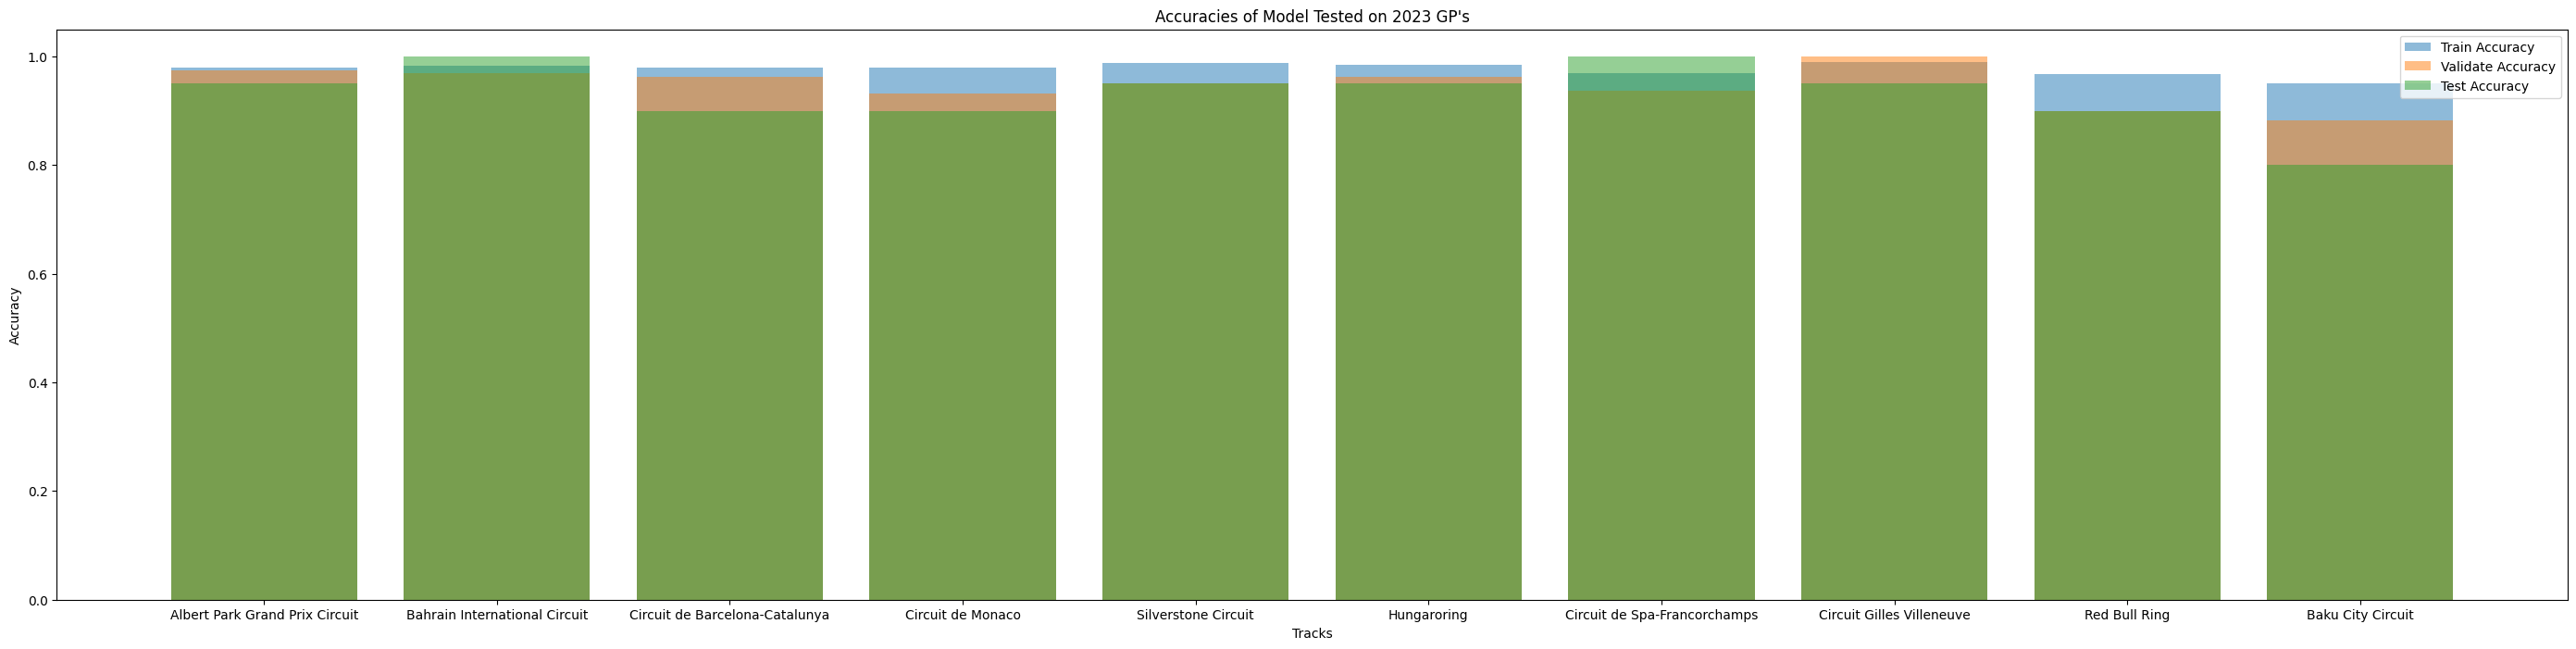

In [79]:
train_scores = []
val_scores = []
test_scores = []

for track in tracks:
    train_score, val_score, test_score = model(track, 'SVM', 'podium')
    train_scores.append(train_score)
    val_scores.append(val_score)
    test_scores.append(test_score)

# Plot accuracies
plt.figure(figsize=(35, 8))
plt.bar([track for track in tracks], train_scores, alpha=0.5, label='Train Accuracy')
plt.bar([track for track in tracks], val_scores, alpha=0.5, label='Validate Accuracy')
plt.bar([track for track in tracks], test_scores, alpha=0.5, label='Test Accuracy')
plt.xlabel('Tracks')
plt.ylabel('Accuracy')
plt.title("Accuracies of Model Tested on 2023 GP's")
plt.legend(loc='best')
plt.show()

In [80]:
training_mean = np.mean(train_scores)
testing_mean = np.mean(test_scores)

print('The mean training set score is:', training_mean)
print('The mean testing set score is:', testing_mean)

The mean training set score is: 0.9774896057299101
The mean testing set score is: 0.93
